In [10]:
import pandas as pd
import numpy as np
import shap
import joblib
import altair as alt
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Load training set

root_directory = '../../../data/train_test_split/'

X_train_transformed = pd.read_csv(root_directory+'x_train_rf.csv')
y_train = pd.read_csv(root_directory+'y_train.csv')['is_drafted']

In [12]:
# Re-train same model

clf = RandomForestClassifier(
    n_estimators = 150,
    min_samples_split = 15,
    min_samples_leaf = 10,
    max_features = 'sqrt',
    max_depth = 15,
    criterion = 'entropy',
    bootstrap = True, 
    random_state = 0,
    class_weight = 'balanced' # Weighted inversely proportional to how frequently the target appears. 
)


clf.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=10, min_samples_split=15,
                       n_estimators=150, random_state=0)

In [13]:
# compute SHAP values
explainer = shap.TreeExplainer(clf, X_train_transformed)
shap_values = explainer(X_train_transformed, check_additivity=False)

100%|===================| 35905/35906 [20:13<00:00]        

In [14]:
# generate feature importance values manually
X_cols = X_train_transformed.columns
# get mean shap value, then take absolute value of that.
shap_vals_df = pd.DataFrame(shap_values.values[:,:, 1], columns = X_cols)
shap_vals_mean = shap_vals_df.mean().abs()

# Store in Pandas df
df_shap_vals_mean = pd.DataFrame(shap_vals_mean)
df_shap_vals_mean = df_shap_vals_mean.reset_index()
df_shap_vals_mean.columns = ['feature', 'importance']
df_shap_vals_mean = df_shap_vals_mean.sort_values(by = 'importance', ascending = False).head(20)

# Plot with altair
alt.Chart(df_shap_vals_mean).mark_bar(color = '#FD015E').encode(
    y = alt.Y('feature', sort = '-x', title = ' '), 
    x = alt.X('importance', title = 'Average Absolute Change in Prediction')
).properties(title={
      "text": ["Top 20 Most Important Features of Random Forest"],
      "subtitle": ["Defined by average change in the prediction when excluded from model"]
}, height = 600, width = 300)
            

alt.Chart(...)

In [15]:
# generate feature importance values manually

# get mean shap value, then take absolute value of that.
shap_vals_df = pd.DataFrame(shap_values.values[:,:, 1], columns = X_cols)
shap_vals_mean = shap_vals_df.mean()

# Store in Pandas df
df_shap_vals_mean = pd.DataFrame(shap_vals_mean)
df_shap_vals_mean = df_shap_vals_mean.reset_index()
df_shap_vals_mean.columns = ['feature', 'importance']
df_shap_vals_mean['Correlation with Draft Likelihood'] = np.where(df_shap_vals_mean['importance'] <=0, 'negative', 'positive')


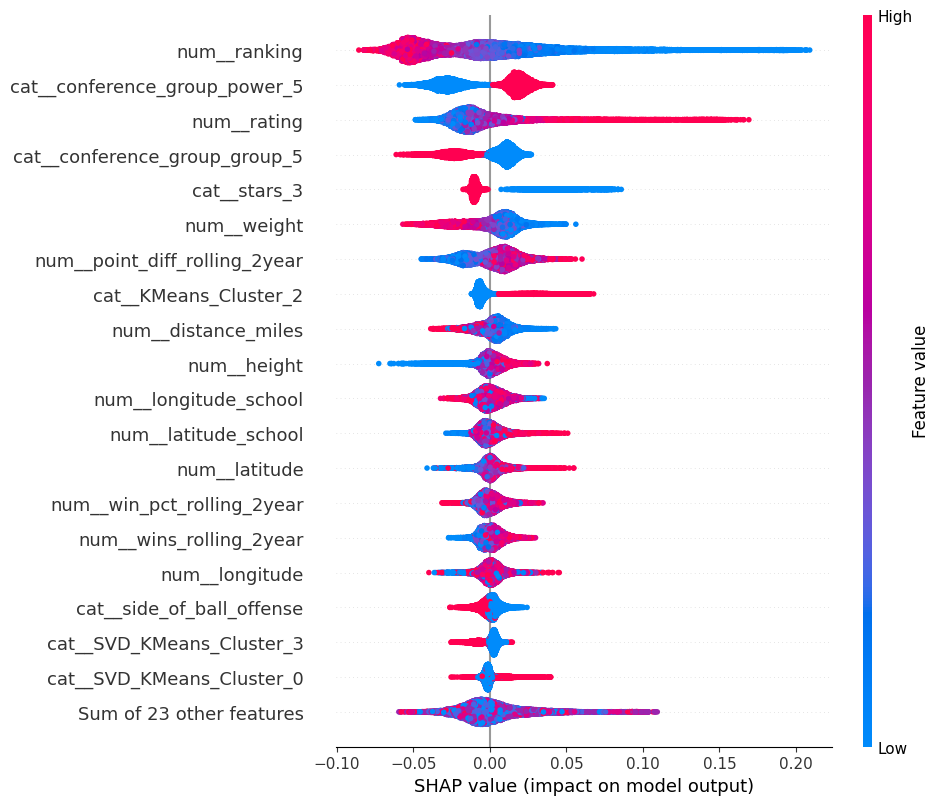

In [30]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20)

In [60]:
# imp = result.importances_mean
features = X_train_transformed.columns

a = zip(features, clf.feature_importances_)
df_imp = pd.DataFrame(a, columns = ['Feature', 'Importance (MDI)'])

df_imp = df_imp.sort_values(by = 'Importance (MDI)', ascending = False).head(20)

# Plot with altair
alt.Chart(df_imp).mark_bar(color = '#FD015E').encode(
    y = alt.Y('Feature', sort = '-x', title = ' '), 
    x = alt.X('Importance (MDI)', title = 'Importance (MDI)')
).properties(title={
      "text": ["Top 20 Most Important Features of Random Forest"],
      "subtitle": ["Defined by Mean Decrease in Impurity (MDI)"]
}, height = 600, width = 300
            )

alt.Chart(...)

In [62]:
# imp = result.importances_mean
features = X_train_transformed.columns

a = zip(features, clf.feature_importances_)
df_imp = pd.DataFrame(a, columns = ['Feature', 'Importance (MDI)'])

df_imp = df_imp.sort_values(by = 'Importance (MDI)', ascending = True).head(20)
df_imp

,Feature,Importance (MDI)
8,cat__conference_group_independent,0.000962
6,cat__side_of_ball_special,0.001407
19,cat__position_group_special,0.001483
27,cat__KMeans_Cluster_3,0.001743
11,cat__position_group_athlete,0.001971
17,cat__position_group_qb,0.002174
3,cat__side_of_ball_athlete,0.002323
22,cat__SVD_KMeans_Cluster_2,0.002898
10,cat__conference_group_unknown,0.003193
18,cat__position_group_running_back,0.003207


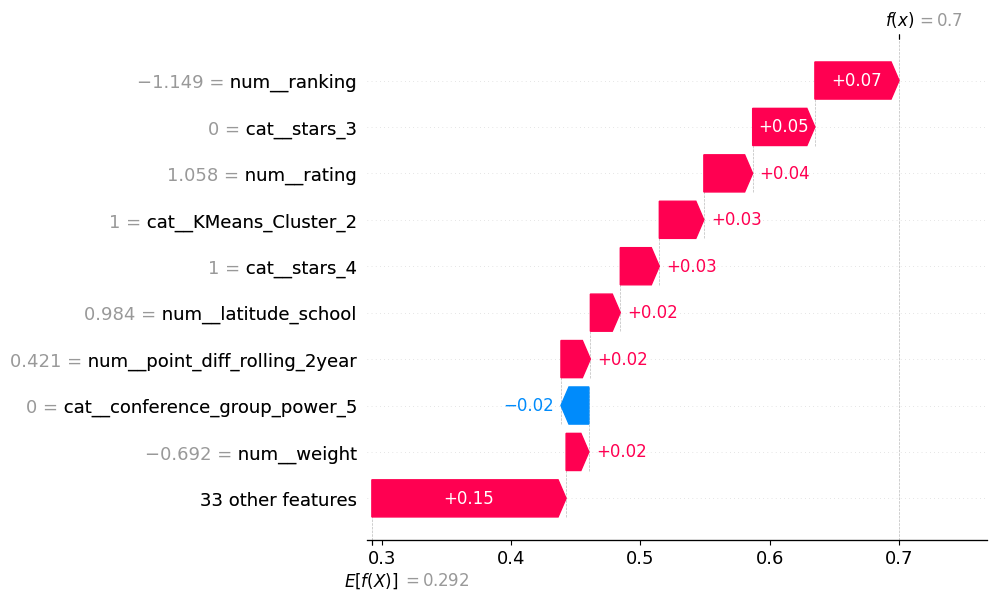

In [18]:
i = 0

shap.plots.waterfall(shap_values[i][:,1], max_display = 10)

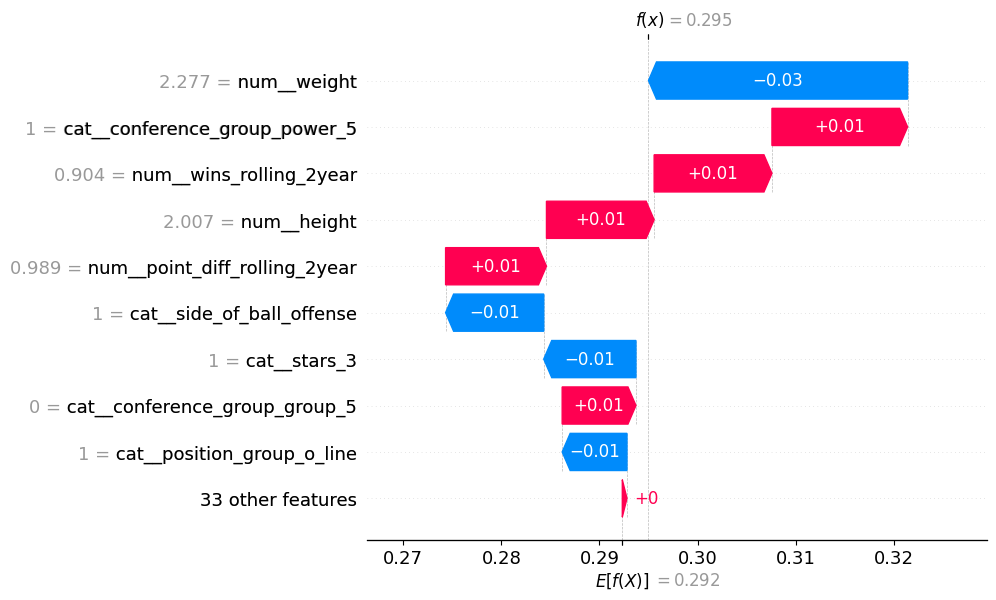

In [19]:
i = 90

shap.plots.waterfall(shap_values[i][:,1])

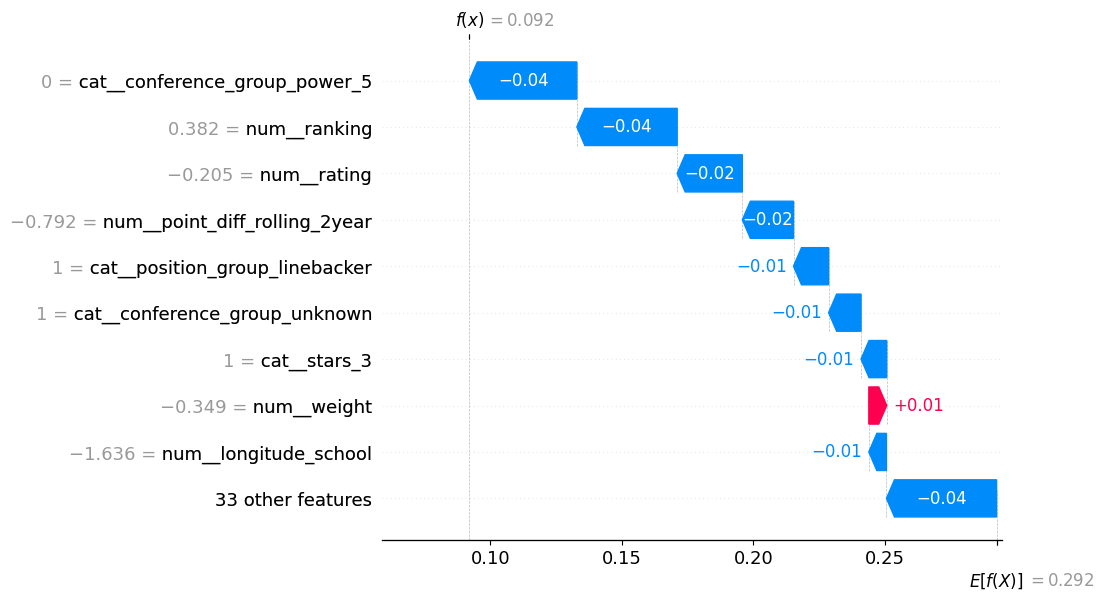

In [20]:
i = 6

shap.plots.waterfall(shap_values[i][:,1])

In [21]:
# Values: Each data points impact on likelihood of drafting
# shap_values.values[: , : ,0]

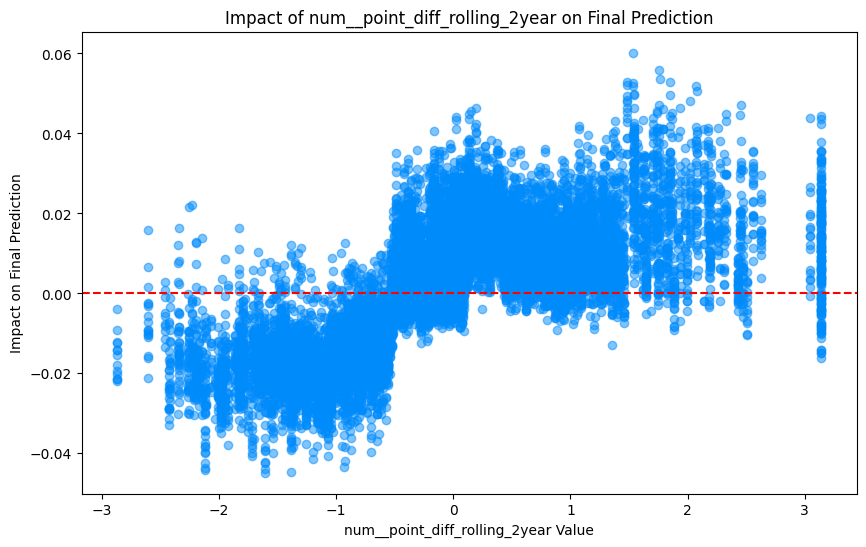

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def dependence_plot(feature, fig_size = (10,6)):

    # Choose a feature and create df from shap values
    # feature = 'num__point_diff_rolling_2year'
    shap_vals_df = pd.DataFrame(shap_values.values[:,:, 1], columns = X_cols)
    
    # get shap values and actual feature values for that feature
    x_axis = X_train_transformed[feature]
    y_axis = shap_vals_df[feature]
    
    # Create a scatter plot with a larger size
    plt.figure(figsize=fig_size)
    plt.scatter(x_axis, y_axis, c='#008BFB', alpha = .5)
    
    # Add a dotted horizontal line at y = 0
    plt.axhline(y=0, color='r', linestyle='--')
    
    # Add labels and title
    plt.xlabel(feature + " Value")
    plt.ylabel("Impact on Final Prediction")
    plt.title("Impact of " + feature + " on Final Prediction")
    
    # Show the plot
    plt.show()


dependence_plot('num__point_diff_rolling_2year')

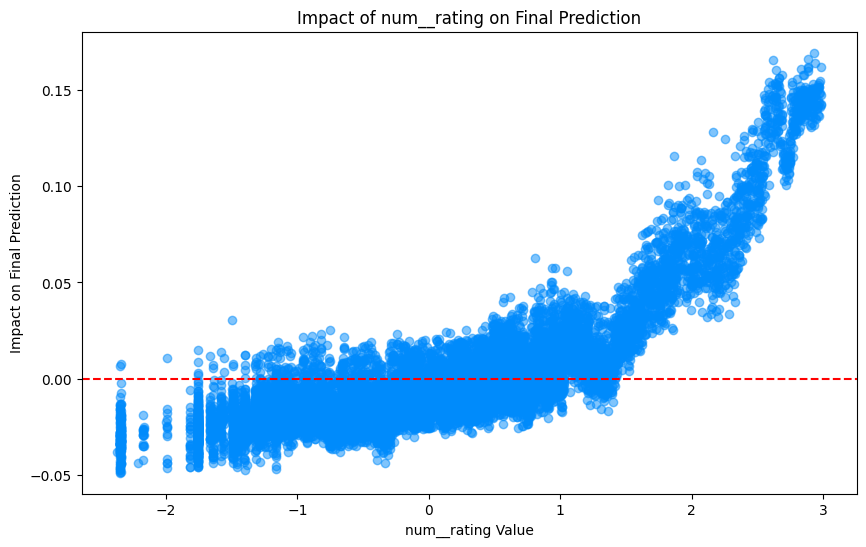

In [57]:
dependence_plot('num__rating')

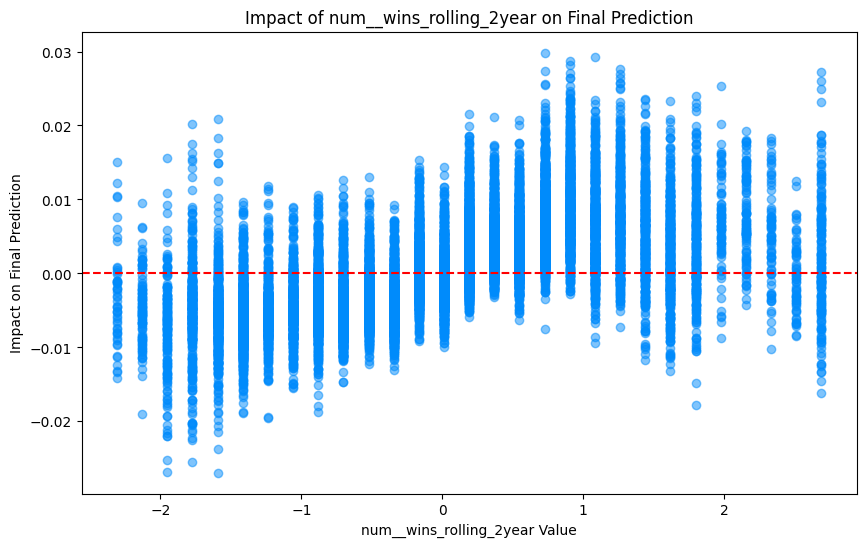

In [64]:
dependence_plot('num__wins_rolling_2year')

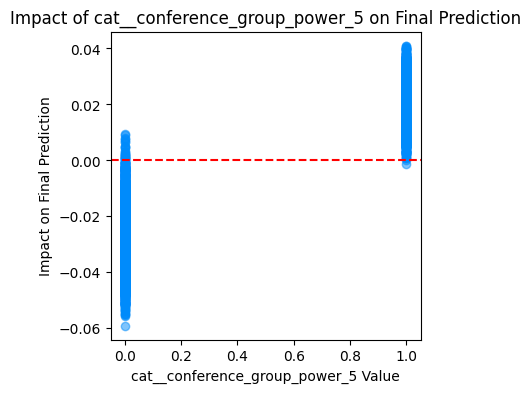

In [58]:
dependence_plot('cat__conference_group_power_5', (4,4))

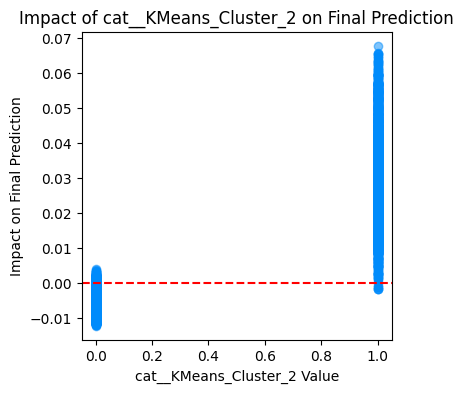

In [59]:
dependence_plot('cat__KMeans_Cluster_2', (4,4))

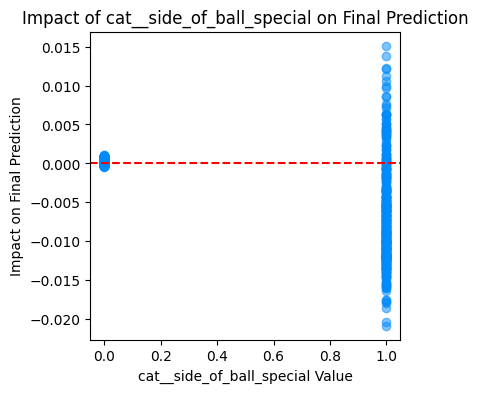

In [63]:
dependence_plot('cat__side_of_ball_special', (4,4))

In [26]:
# save shap values for future to avoid running agian
import joblib

joblib.dump(shap_values, 'rf_final_shapvalues')
# values = joblib.load('rf_final_shapvalues')

['rf_final_shapvalues']